# Transfer Learning for Glacier Mass Balance Prediction

1. **Load a pre-trained neural network** trained on Swiss glacier data
2. **Fine-tune it on French glacier data** using various strategies
3. **Evaluate performance** on unseen French glaciers

---

## Prerequisites
- Pre-trained model on all Swiss data from ../regions/Switzerland/3.2.2 Train-ML-model-NN.ipynb e.g. `nn_model_2025-07-14_CH_flexible.pt`
- French glacier dataset from ../regions/France/1.1. GLACIOCLIM-prepro.ipynb
- ERA5 climate data of France from ../regions/France/1.2. ERA5Land-prepro.ipynb

---


In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v", # OGGM
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

else:
    print("CUDA is NOT available")


CUDA is available


## Data Loading & Preprocessing

### Create French Glacier Dataset
Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_glacioclim = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
#print('Number of summer samples:',
      #len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim = data_glacioclim[data_glacioclim['PERIOD'] != 'summer']

data_glacioclim.columns


Number of glaciers: 9
Number of winter, summer and annual samples: 10762
Number of annual samples: 4785
Number of winter samples: 3281


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

In [5]:
data_glacioclim_test = data_glacioclim.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full_no_summer_with_blanc.csv')
data_monthly = dataloader_gl.data

2025-10-16 17:57:01,471 - INFO - Loaded preprocessed data.
2025-10-16 17:57:01,472 - INFO - Number of monthly rows: 81534
2025-10-16 17:57:01,484 - INFO - Number of annual samples: 57592
2025-10-16 17:57:01,492 - INFO - Number of winter samples: 23942


## Train/Test Split Strategies


### Limited Data Split (5-10% for fine-tuning)

**Data**: About 5-10 % of the available data is used as fine-tuning set

**Use case**: Test performance with minimal fine-tuning data (~500 measurements) to simulate data-scarce scenarios.

In [6]:
# TRANSFER LEARNING SETUP 5-10%
# Fine-tuning glaciers 5-10%
train_glaciers = ['FR4N01163A02 de Sarennes 1', 'FR4N01236A07 de Talefre', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']

# Test glaciers (all remaining France glaciers)
all_france_glaciers = list(data_glacioclim['GLACIER'].unique())
test_glaciers = [g for g in all_france_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

Fine-tuning glaciers (4): ['FR4N01163A02 de Sarennes 1', 'FR4N01236A07 de Talefre', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']
Test glaciers (5): ['FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz', 'FR4N01083B21 Blanc', 'FR4N01236A01 Mer de Glace/Geant', 'FR4N01162B09+154D03 de Saint Sorlin']
Train glaciers: (4) ['FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01236A02 des Grands Montets']
Test glaciers: (5) ['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01083B21 Blanc' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01162B09+154D03 de Saint Sorlin']


'length train set'

6468

'length test set'

75066

## Validation Split

### Random 80/20 Split

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
FR4N01236A01 Leschaux              2409
FR4N01236A07 de Talefre            2251
FR4N01163A02 de Sarennes 1          459
FR4N01236A02 des Grands Montets      81
Name: count, dtype: int64
Val data glacier distribution: GLACIER
FR4N01236A01 Leschaux              567
FR4N01236A07 de Talefre            483
FR4N01163A02 de Sarennes 1         191
FR4N01236A02 des Grands Montets     27
Name: count, dtype: int64
Train data shape: (5200, 29)
Val data shape: (1268, 29)


## Neural Network Configuration

### Feature Engineering and Dataset Preparation

In [8]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (5200, 28)
Shape of validation dataset: (1268, 28)
Shape of testing dataset: (75066, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Model Callbacks and Training Configuration
Set up training callbacks and configuration for optimal performance and monitoring.

In [9]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='valid_loss',    # Monitor validation loss
    patience=15,             # Stop after 15 epochs without improvement
    threshold=1e-4,          # Minimum change threshold
)

# Learning rate scheduler for adaptive training
lr_scheduler_cb = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    mode='min',
    factor=0.5,              # Reduce LR by half
    patience=5,              # Wait 5 epochs before reducing
    threshold=0.01,
    threshold_mode='rel',
    verbose=True
)

# Global variables for dataset management
dataset = dataset_val = None

def my_train_split(ds, y=None, **fit_params):
    """Custom train/validation split function for skorch."""
    return dataset, dataset_val

# Model configuration parameters
param_init = {'device': 'cpu'}
nInp = len(feature_columns)  # Number of input features

# Model checkpointing to save best model during training
checkpoint_cb = Checkpoint(
    monitor='valid_loss_best',
    f_params='best_model.pt',
    f_optimizer=None,        # Don't save optimizer state
    f_history=None,          # Don't save training history
    f_criterion=None,        # Don't save criterion state
    load_best=True,          # Load best model after training
)

# Custom callback to save models at specific epochs for analysis
save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])

print('Callbacks and configuration ready!')

Callbacks and configuration ready!


### Dataset Creation
Datasets will be created in the training loop after loading the pre-trained Swiss model to ensure compatible preprocessing.

In [10]:
# Don't create datasets here, create them after loading the Swiss model
features = features_val = None
metadata = metadata_val = None
dataset = dataset_val = None
print("Datasets will be created after loading Swiss model...")

Datasets will be created after loading Swiss model...


## Transfer Learning Execution

### Loading Pre-trained Swiss Model and Fine-tuning on French Data

### Method 1: Standard Fine-tuning with Selective Layer Freezing

After loading the model, all layers will be frozen by default, to unfreeze a layer you have to include it in "if name not in [...]" in Step 3.

 The SaveBestAtEpochs callback automatically saves the current best model at epochs [10, 15, 20, 30, 50, 100], which can then be evaluated in the Epoch-wise model evalution section. Comment out the callback if you don't want this feature. If you do and you continuously want to retrain models at different learning rates, you have to reexecute the "save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])" cell.

In [11]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch to not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
            #('save_best_at_epochs', save_best_epochs_cb)
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    for name, param in loaded_model.module_.named_parameters():
        # Freeze layers
        if name not in [#'model.0.weight', 'model.0.bias',
                        'model.1.weight', 'model.1.bias',
                        #'model.4.weight', 'model.4.bias',
                        'model.5.weight', 'model.5.bias',
                        #'model.8.weight', 'model.8.bias',
                        'model.9.weight', 'model.9.bias',
                        #'model.12.weight', 'model.12.bias',
                        'model.13.weight', 'model.13.bias',
                        #'model.16.weight', 'model.16.bias'
                        ]:
            param.requires_grad = False
    
    # STEP 3: Update for fine-tuning
    print("Updating model for fine-tuning...")
    loaded_model = loaded_model.set_params(
        lr=0.05,
        max_epochs=1,
    )
    
    # STEP 4: Fine-tune
    print("Starting fine-tuning...")
    loaded_model.fit(features, y_train)
    
    # STEP 5: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



Loading pre-trained Swiss model...
✓ Swiss model loaded successfully!
Creating datasets with Swiss model...
train: (522,) (522,)
validation: (131,) (131,)
Updating model for fine-tuning...
Starting fine-tuning...
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        2.2903        9.8940     +  0.0500  0.2355
✓ Fine-tuned model saved as: nn_model_finetuned_2025-10-16


### Method 2: Progressive Layer Unfreezing
This advanced approach gradually unfreezes layers during training for more controlled adaptation to the French data.

In [ ]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    
    # Helper to freeze/unfreeze layers
    def set_requires_grad(layer_names, requires_grad=True):
        for name, param in loaded_model.module_.named_parameters():
            if name in layer_names:
                param.requires_grad = requires_grad

    # List of layer groups to progressively unfreeze
    layer_groups = [
        (
        [
            'model.1.weight', 'model.1.bias',
            'model.5.weight', 'model.5.bias',
            'model.9.weight', 'model.9.bias',
            'model.13.weight', 'model.13.bias'
        ],200,  0.1
    ),
        (['model.16.weight', 'model.16.bias'], 200, 0.001),
        (['model.12.weight', 'model.12.bias'], 200, 0.001),
        (['model.8.weight', 'model.8.bias'], 200, 0.001)
    ]

    # Freeze all layers first
    for name, param in loaded_model.module_.named_parameters():
        param.requires_grad = False

    # Progressive unfreezing loop with custom learning rates
    for layers, epochs, lr in layer_groups:
        set_requires_grad(layers, True)
        print(f"Fine-tuning layers: {layers} for {epochs} epochs with lr={lr}...")
        loaded_model = loaded_model.set_params(lr=lr, max_epochs=epochs)
        loaded_model.fit(features, y_train)

        val_score = loaded_model.score(dataset_val.X, dataset_val.y)
        print("Validation score:", val_score)
    
    # STEP 3: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



### Model Evaluation

#### Quick Performance Evaluation
Get immediate performance metrics on the test set using the fine-tuned model.

In [12]:
# Quick comprehensive evaluation of the fine-tuned model
print("Evaluating fine-tuned model performance...")

grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm
)

print("Test Set Performance Metrics:")
display(scores_NN)

# Validation score for confirmation that model with the best val_loss is used
val_score = loaded_model.score(dataset_val.X, dataset_val.y)
print(f"Validation score (for reference): {val_score:.4f}")

# Calculate additional performance metrics by glacier
print("\nPerformance by glacier:")
glacier_performance = grouped_ids.groupby('GLACIER').apply(
    lambda x: pd.Series({
        'n_samples': len(x),
        'rmse': np.sqrt(np.mean((x['target'] - x['pred'])**2)),
        'mae': np.mean(np.abs(x['target'] - x['pred'])),
        'r2': 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2),
        'Bias': np.mean(x['pred'].values - x['target'].values)
    })
).round(4)

display(glacier_performance.sort_values('rmse'))

Evaluating fine-tuned model performance...
Test Set Performance Metrics:


{'score': -8.701319033181454,
 'mse': 8.701319051329575,
 'rmse': 2.949799832417375,
 'mae': 2.5291343530374304,
 'pearson': 0.9115977614974818}

Validation score (for reference): -9.8940

Performance by glacier:


,n_samples,rmse,mae,r2,Bias
GLACIER,,,,,
FR4N01146D09+E06 Gebroulaz,1285.0,2.2936,1.8680,-0.6579,-1.8597
FR4N01162B09+154D03 de Saint Sorlin,2163.0,2.7215,2.3774,-1.2879,-2.3746
FR4N01236A01 Mer de Glace/Geant,1185.0,2.8786,2.5139,0.4230,-2.4903
FR4N01235A08 dArgentiere,2513.0,3.1477,2.7361,-0.8977,-2.7325
FR4N01083B21 Blanc,267.0,5.1217,5.0599,-9.2763,-5.0599


#### Epoch-wise Model Evaluation
Evaluate models saved at different training epochs to understand training dynamics and optimal stopping points.

In [ ]:
# Evaluate models saved at different epochs to analyze training dynamics
print("Evaluating models saved at different training epochs...")

epochs_to_evaluate = [10, 15, 20, 30, 50, 100]
model_prefix = "nn_model_best_epoch"

epoch_results = {}

for epoch in epochs_to_evaluate:
    model_name = f"{model_prefix}_{epoch}.pt"
    
    # Check if model file exists
    if not os.path.exists(model_name):
        print(f"Model for epoch {epoch} not found, skipping...")
        continue

    print(f"Evaluating model at epoch {epoch}...")
    
    # Load model with same architecture as Swiss model
    epoch_model = mbm.models.CustomNeuralNetRegressor(
        cfg, **swiss_args, **param_init
    )
    epoch_model = epoch_model.set_params(device='cpu').to('cpu')
    epoch_model.initialize()
    
    # Load saved weights
    state_dict = torch.load(model_name, map_location='cpu')
    epoch_model.module_.load_state_dict(state_dict)

    # Evaluate the model
    grouped_ids_epoch, scores_NN_epoch, ids_NN_epoch, y_pred_NN_epoch = evaluate_model_and_group_predictions(
        epoch_model, df_X_test_subset, test_set['y'], cfg, mbm
    )
    
    # Store results
    epoch_results[epoch] = scores_NN_epoch
    
    print(f"Epoch {epoch} performance:")
    display(scores_NN_epoch)
    print("-" * 50)

print("Epoch-wise evaluation completed!")

# Compare performance across epochs
if epoch_results:
    print("\nPerformance comparison across epochs:")
    comparison_df = pd.DataFrame(epoch_results).T
    comparison_df.index.name = 'Epoch'
    display(comparison_df.round(4))

#### Comprehensive Visualization and Analysis
Generate detailed visualizations to understand model performance across different glaciers and time periods.

In [13]:
# Prepare comprehensive visualization data
print("Preparing data for comprehensive visualizations...")

# Create features and metadata for final evaluation
features_test, metadata_test = loaded_model._create_features_metadata(df_X_test_subset)

# Ensure all tensors are on CPU for visualization
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()
if hasattr(test_set['y'], 'cpu'):
    targets_test = test_set['y'].cpu()
else:
    targets_test = test_set['y']

# Create final test dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),  # Features
    SliceDataset(dataset_test, idx=1)   # Targets
]

# Generate final predictions
print("Generating final predictions for visualization...")
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

# Prepare evaluation metrics
batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate comprehensive performance metrics
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

print(f"Final Model Performance Summary:")
print(f"   R² Score: {score:.4f}")
print(f"   RMSE: {rmse:.4f} mm w.e.")
print(f"   MAE: {mae:.4f} mm w.e.")
print(f"   Pearson r: {pearson:.4f}")

# Create comprehensive results DataFrame
id = dataset_test[0].dataset.indexToId(batchIndex)
grouped_ids = pd.DataFrame({
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
})

# Add comprehensive metadata
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

print("Visualization data prepared successfully!")

Preparing data for comprehensive visualizations...
Generating final predictions for visualization...
Final Model Performance Summary:
   R² Score: -8.7013
   RMSE: 2.9498 mm w.e.
   MAE: 2.5291 mm w.e.
   Pearson r: 0.9116
Visualization data prepared successfully!


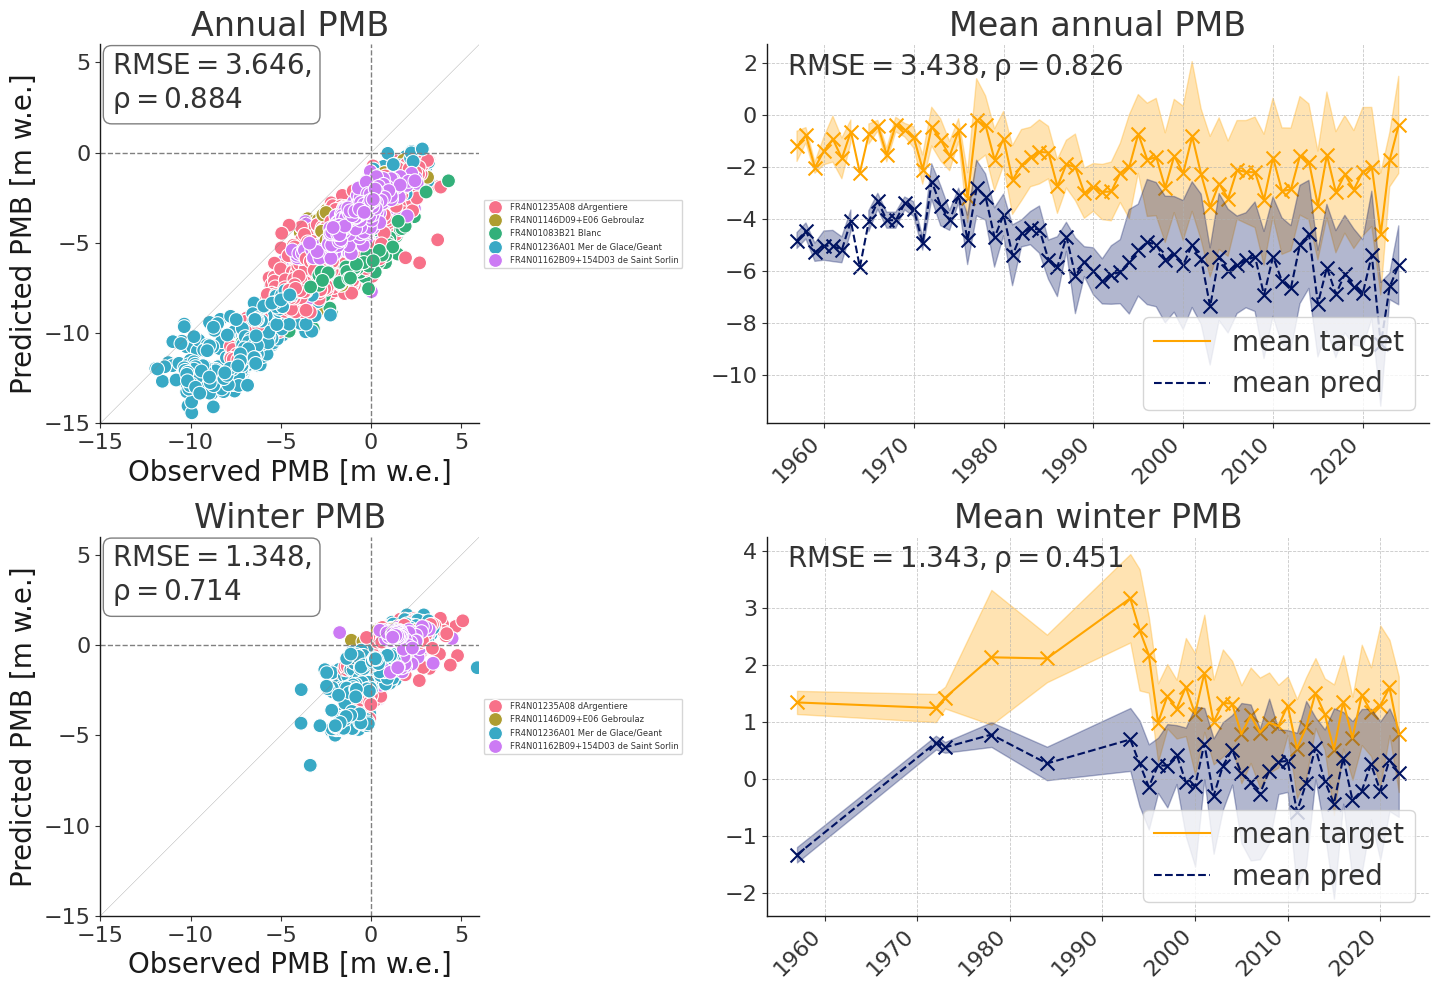

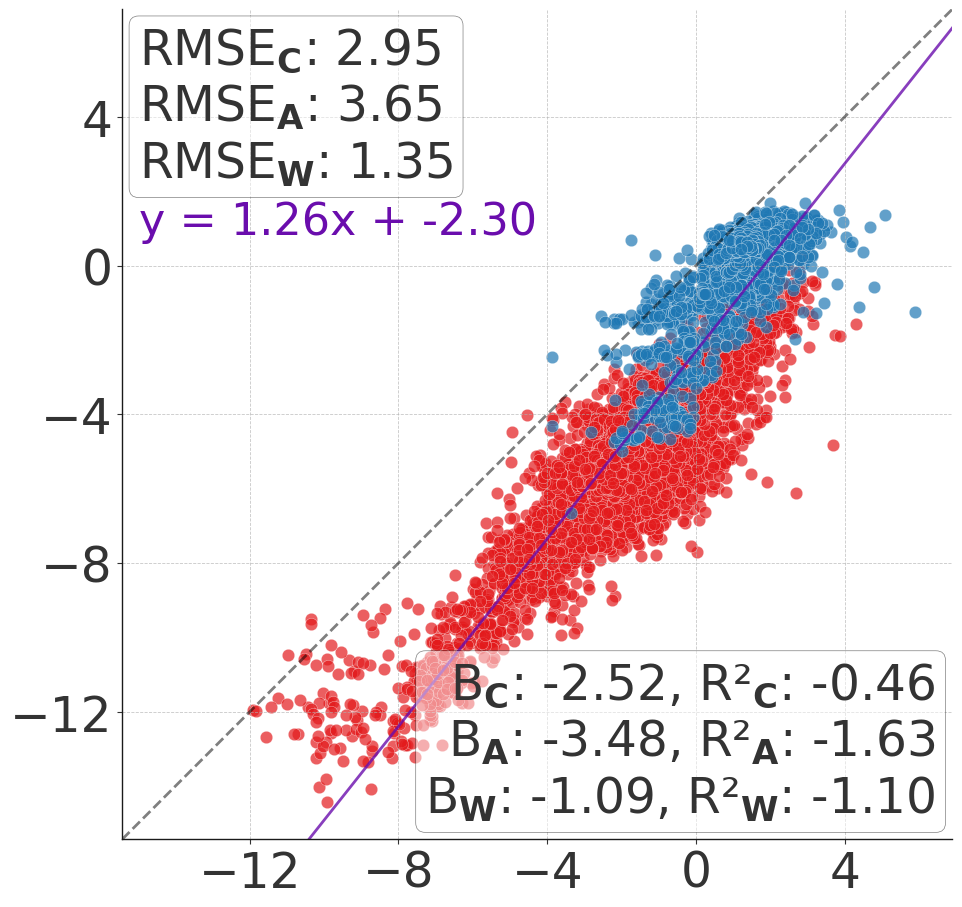

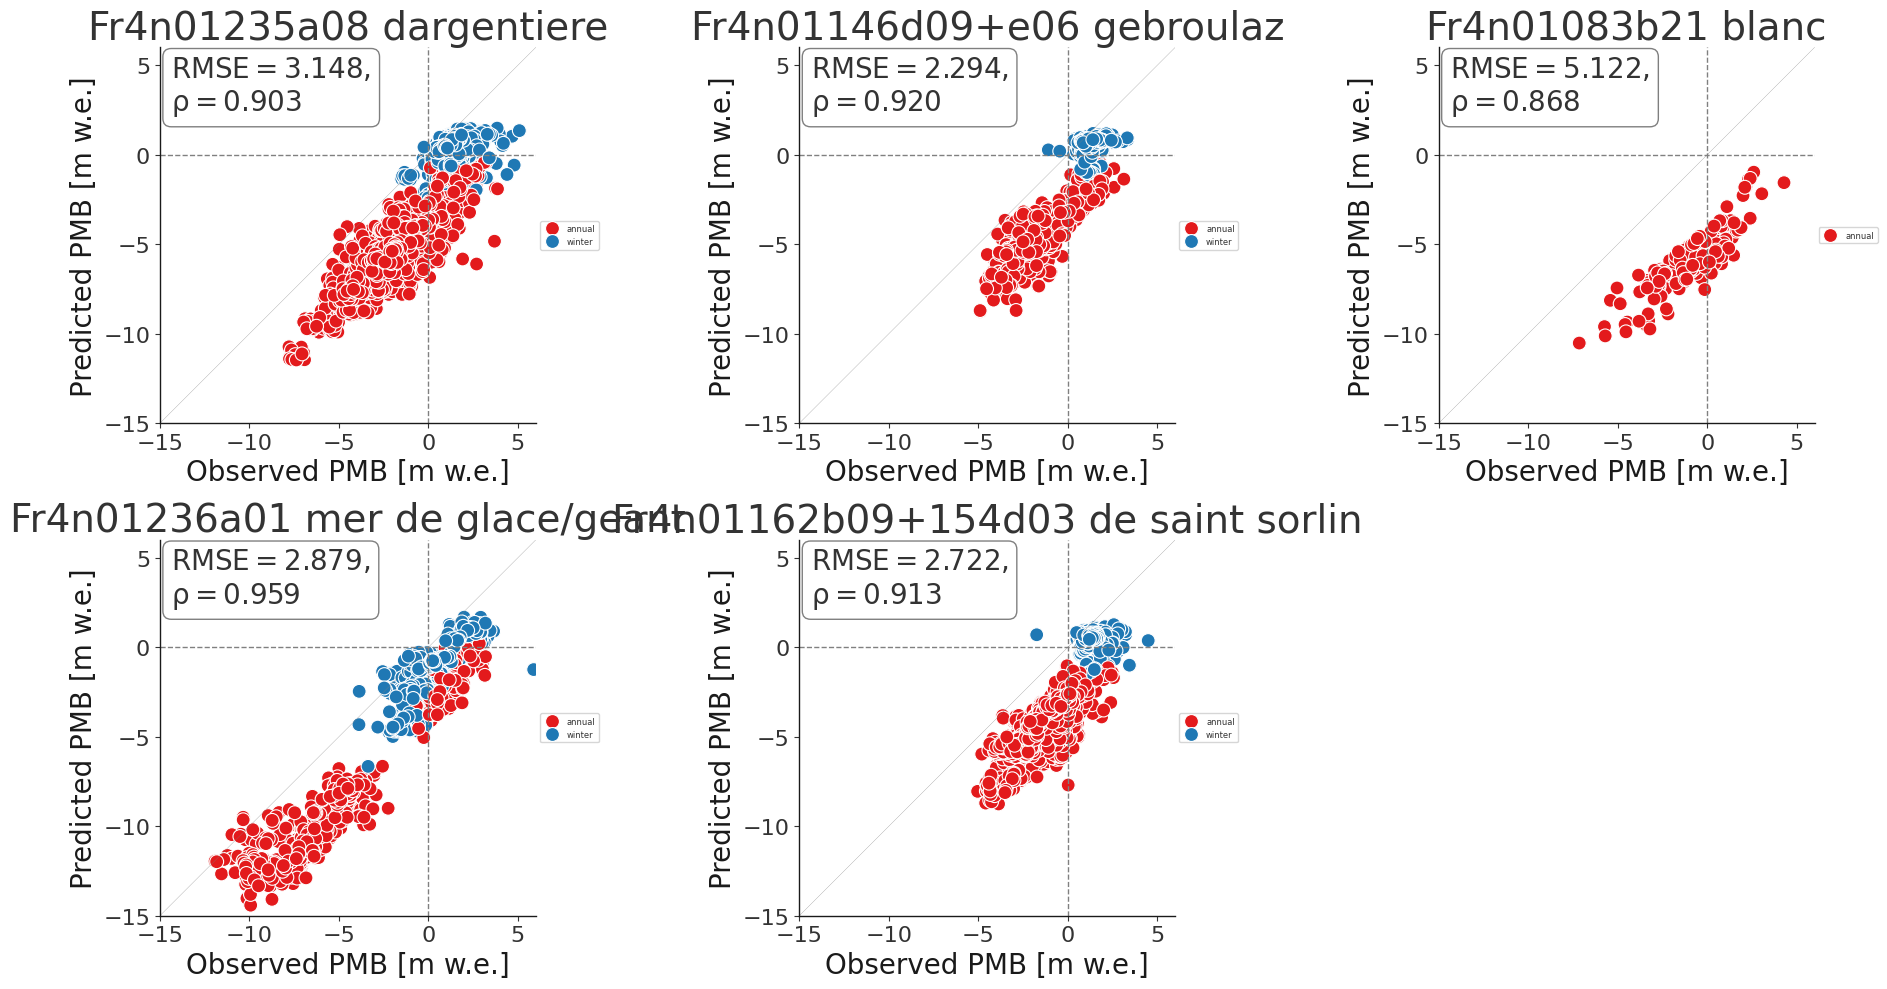

In [14]:
PlotPredictions_NN(grouped_ids)

PlotPredictionsCombined_NN_additional(grouped_ids)

PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))


##### Visualization of all model strategies

In [15]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss (optional during training)
        """
        # Simple domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_nor = [], []

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=NOR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

params_dann = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args_dann = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params_dann['module__dropout'],
    'module__hidden_layers': params_dann['module__hidden_layers'],
    'module__use_batchnorm': params_dann['module__use_batchnorm'],
    'module__domain_hidden': params_dann['module__domain_hidden'],
    'module__grl_lambda': params_dann['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params_dann['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params_dann['lr'],
    'max_epochs': 200,
    'optimizer': params_dann['optimizer'],
    'optimizer__weight_decay': params_dann['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

Loading Regional Baseline: nn_model_2025-08-24_5-10%_3rd_try_regional_baseline.pt
Loading CH and Regional Baseline: nn_model_2025-08-24_5-10%_CH_and_5-10%_baseline_only_FR_val.pt
Loading Fine-tuning: nn_model_finetuned_2025-08-24_5-10%__3rd_try_fine_tuning_lr0.0005_epoch_10.pt
Loading Batchnorm Unfrozen: nn_model_finetuned_2025-08-24_5-10%_3rd_try_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt
Loading DANN: dann_model_2025-08-24_5-10%_lamba0_05_mean_domainloss_even_domainloss_only_FR_val_50_50epochsplit.pt


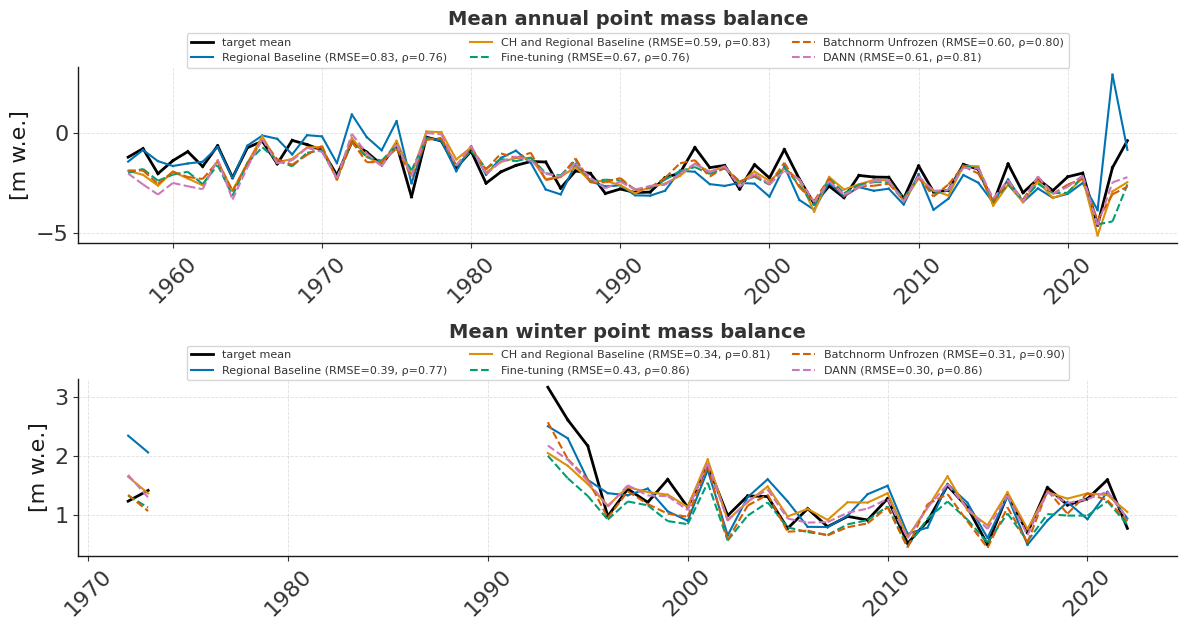

In [18]:
def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()


    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 8))


    ax_ann.set_title('Mean annual point mass balance', fontsize=14, fontweight='bold', pad=30)
    ax_win.set_title('Mean winter point mass balance', fontsize=14, fontweight='bold', pad=30)


    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}


    regional_models = ['Regional Baseline', 'CH and Regional Baseline']
    transfer_models = ['Fine-tuning', 'Batchnorm Unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models} 
    line_styles.update({model: '--' for model in transfer_models}) 

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())


        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        
        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1:  
                if not target_line_plotted:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="target mean")
                    target_line_plotted = True
                else:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6)
        
        if not target_line_plotted:
            ax.plot(available_years, available_values, color="black", marker='x', markersize=6,
                   linestyle='None', label="target mean")

        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()

            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            
            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            label_added = False  
            
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1:  
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label_with_metrics if not label_added else "")
                    label_added = True
            

            if not label_added and len(pred_years) > 0:
                ax.plot([], [], 
                       color=label_to_color.get(label, None), 
                       linestyle=line_styles.get(label, '-'),
                       label=label_with_metrics)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')


    ax_ann.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))
    ax_win.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))


    ax_ann.set_ylabel('[m w.e.]')
    ax_win.set_ylabel('[m w.e.]')

    plt.tight_layout(rect=(0, 0, 1, 0.8))  
    plt.show()


base = grouped_ids[['ID', 'target', 'PERIOD', 'GLACIER', 'YEAR']].copy()

# List models (optionally mix NN and DANN). Provide up to 5.
#5-10%
models = [
    #('CH Baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Regional Baseline',  'nn_model_2025-08-24_5-10%_3rd_try_regional_baseline.pt', mbm.models.CustomNeuralNetRegressor),
    ('CH and Regional Baseline',  'nn_model_2025-08-24_5-10%_CH_and_5-10%_baseline_only_FR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-24_5-10%__3rd_try_fine_tuning_lr0.0005_epoch_10.pt', mbm.models.CustomNeuralNetRegressor),
    ('Batchnorm Unfrozen',  'nn_model_finetuned_2025-08-24_5-10%_3rd_try_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-24_5-10%_lamba0_05_mean_domainloss_even_domainloss_only_FR_val_50_50epochsplit.pt', CustomDANNRegressor),
]

device = 'cpu'

nn_loader_args = {**swiss_args, **param_init}
try:
    _ = DANNNetwork
    dann_loader_args = {
        **{
            **args_dann,
            'module': DANNNetwork,
            'module__domain_hidden': params_dann.get('module__domain_hidden', 64),
            'module__grl_lambda': params_dann.get('module__grl_lambda', 1.0),
        },
        'dan_lambda': 0.05,  # inference-only, safe if different from train
        **param_init,
    }
except NameError:
    dann_loader_args = None

models_grouped = {}

for label, fname, model_cls in models:
    print(f'Loading {label}: {fname}')

    if model_cls.__name__ == 'CustomDANNRegressor':
        if dann_loader_args is None:
            raise NameError("DANNNetwork not available. Run the DANN components cell before loading DANN models.")
        mdl = model_cls.load_model(cfg, fname, **dann_loader_args)
    else:
        mdl = model_cls.load_model(cfg, fname, **nn_loader_args)

    mdl = mdl.set_params(device=device).to(device)

    # Predict aggregated by measurement ID using the same dataset_test
    y_pred_agg = mdl.aggrPredict(dataset_test[0])

    assert len(y_pred_agg) == len(base), f'Length mismatch for {label}'
    gdf = base.copy()
    gdf['pred'] = y_pred_agg
    models_grouped[label] = gdf

# Plot mean annual and mean winter PMB for all models together
plot_mean_pmb_multi_fixed_lines(models_grouped)

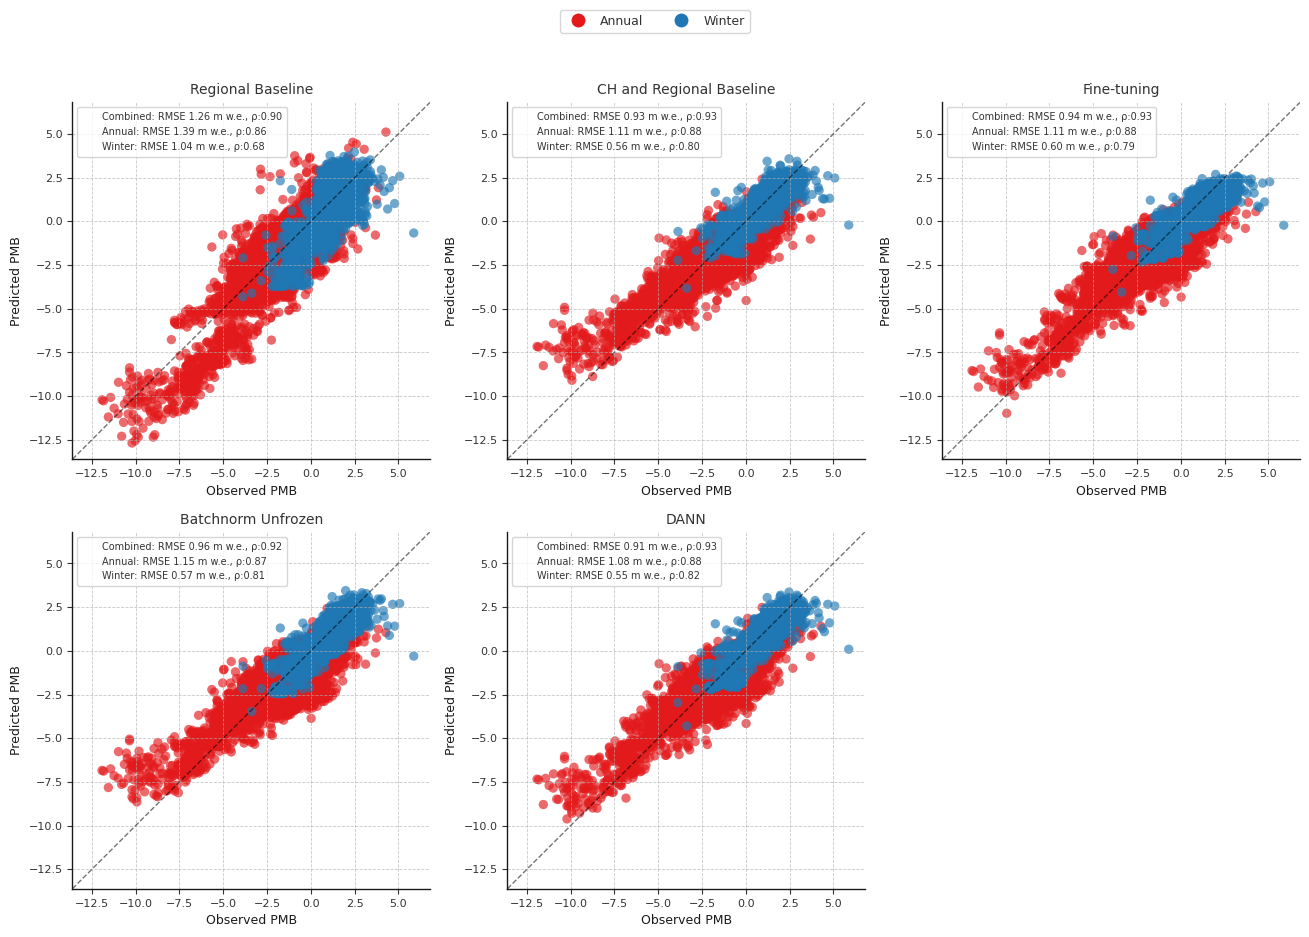

In [17]:
def plot_pred_vs_obs_grid(models_grouped, ncols=3, point_size=45, region_name='CH->FR'):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    period_colors = {'annual': '#e31a1c', 'winter': '#1f78b4'}
    labels = list(models_grouped.keys())
    n_models = len(labels)
    ncols_eff = min(ncols, n_models)
    nrows = int(np.ceil(n_models / ncols_eff))

    # Global axis limits
    all_targets = np.concatenate([models_grouped[l].target.values for l in labels])
    all_preds   = np.concatenate([models_grouped[l].pred.values   for l in labels])
    gmin = np.nanmin([all_targets.min(), all_preds.min()])
    gmax = np.nanmax([all_targets.max(), all_preds.max()])
    pad = 0.05 * (gmax - gmin)
    gmin -= pad
    gmax += pad

    fig, axes = plt.subplots(nrows, ncols_eff,
                             figsize=(4.4 * ncols_eff, 4.6 * nrows),
                             squeeze=False)
    metrics_all = {}

    for i, label in enumerate(labels):
        r, c = divmod(i, ncols_eff)
        ax = axes[r][c]
        df_plot = models_grouped[label]
        df_plot = df_plot[df_plot.PERIOD.isin(['annual','winter'])].copy()

        # Metrics per period
        panel_metrics = {}
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                y_t = sub.target.values
                y_p = sub.pred.values
                rmse = np.sqrt(np.mean((y_p - y_t)**2))
                rho  = np.corrcoef(y_t, y_p)[0,1] if len(sub) > 1 else np.nan
                panel_metrics[period] = (rmse, rho)

        # Combined
        y_t_all = df_plot.target.values
        y_p_all = df_plot.pred.values
        rmse_all = np.sqrt(np.mean((y_p_all - y_t_all)**2))
        rho_all  = np.corrcoef(y_t_all, y_p_all)[0,1] if len(df_plot) > 1 else np.nan
        panel_metrics['combined'] = (rmse_all, rho_all)
        metrics_all[label] = panel_metrics

        # Scatter (no per‑subplot point handles; handled globally)
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                ax.scatter(sub.target, sub.pred,
                           s=point_size, alpha=0.65, edgecolor='none',
                           color=period_colors[period])

        # 1:1 line + handle for subplot legend
        ax.plot([gmin,gmax],[gmin,gmax],'k--',linewidth=1,alpha=0.55)

        # Metric legend entries
        def metric_handle(name, key):
            rmse, rho = panel_metrics[key]
            return Line2D([],[], linestyle='',
                          label=f"{name}: RMSE {rmse:.2f} m w.e., ρ:{rho:.2f}",
                          color='none')

        metric_handles = [
            metric_handle("Combined", 'combined'),
            *( [metric_handle("Annual", 'annual')] if 'annual' in panel_metrics else [] ),
            *( [metric_handle("Winter", 'winter')] if 'winter' in panel_metrics else [] ),
        ]

        ax.set_xlim(gmin,gmax)
        ax.set_ylim(gmin,gmax)
        ax.set_title(label, fontsize=10)
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Observed PMB', fontsize=9)
        ax.set_ylabel('Predicted PMB', fontsize=9)

        # Subplot legend: only 1:1 + metrics
        ax.legend(handles=metric_handles,
                  fontsize=7, loc='upper left',
                  frameon=True, handlelength=1.2, borderpad=0.5)

    # Hide unused axes
    for j in range(n_models, nrows * ncols_eff):
        r, c = divmod(j, ncols_eff)
        axes[r][c].axis('off')

    # Global legend for point types (annual / winter)
    global_point_handles = [
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['annual'],
               label='Annual'),
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['winter'],
               label='Winter')
    ]
    fig.legend(handles=global_point_handles,
               loc='upper center',
               ncol=2,
               frameon=True,
               fontsize=9,
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=(0,0,1,0.95))
    return metrics_all

pred_grid_metrics = plot_pred_vs_obs_grid(models_grouped, ncols=3, region_name='CH->FR')